In [7]:
import random  # for reproducibility in sampling and shuffling
from pathlib import Path  # filesystem path manipulation

# 2. Data handling and preprocessing
import numpy as np  # numerical operations
import pandas as pd  # dataframes and tabular data

# 3. Visualization
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # statistical data visualization

# 4. Deep learning (PyTorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# 5. Machine learning utilities (scikit-learn)
from sklearn.preprocessing import LabelEncoder, StandardScaler  # encoding labels and feature scaling
from sklearn.model_selection import train_test_split  # data splitting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score  # evaluation metrics

# 6. Learning rate schedulers
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR, OneCycleLR  # dynamic LR scheduling

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Configure seaborn aesthetics
sns.set(style='whitegrid', context='notebook')

In [8]:
# Dataset file paths
TRAIN_CSV = "/kaggle/input/har-dataset-2/train_data_2.csv"  # Path to training data CSV
TEST_CSV  = "/kaggle/input/har-dataset-2/test_data_2.csv"   # Path to testing data CSV

# Windowing and batching parameters
WINDOW_SIZE = 600           # Number of timesteps per sliding window
BATCH_SIZE = 32             # Number of samples per training batch
SAMPLING_FREQ = 200         # Data sampling frequency in Hz
ADD_FEATS = False           # Whether to add derived features beyond raw sensor data

# Battery threshold for sensor gating (e.g., audio on/off)
BATTERY_LOW_THRESHOLD = 0.20  # If battery < 20%, restrict to low-power mode

# Detect compute device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Processing Utilities and Dataset Preparation
This cell defines utility functions to select sensor channels, split data into training and validation sets, and loads, preprocesses, encodes, and wraps data in PyTorch datasets and dataloaders.

In [9]:
class DataPreprocessor:
    def __init__(self, window_size=600, sampling_freq=200, target_samples=32):
        self.window_size = window_size
        self.sampling_freq = sampling_freq
        self.target_samples = target_samples

    def moving_average_filter(self, data, window=8):
        return data.rolling(window=window, center=True).mean().fillna(data)

    def segment_data(self, data, overlap=0.7):
        segments = []
        labels_io = []
        labels_scene = []
        step_size = int(self.window_size * (1 - overlap))

        for i in range(0, len(data) - self.window_size, step_size):
            window = data.iloc[i:i+self.window_size]

            if len(window['I/O Detection'].unique()) == 1 and \
               len(window['Scene Identification'].unique()) == 1:
                segments.append(window)
                labels_io.append(window['I/O Detection'].iloc[0])
                labels_scene.append(window['Scene Identification'].iloc[0])

        return segments, labels_io, labels_scene

    def downsample_segment(self, segment, sensor_cols):
        downsampled = {}
        for col in sensor_cols:
            if col in segment.columns:
                original_data = segment[col].values
                indices = np.linspace(0, len(original_data) - 1, self.target_samples, dtype=int)
                downsampled[col] = original_data[indices]
            else:
                downsampled[col] = np.zeros(self.target_samples)
        return downsampled

    def z_score_normalize(self, segment_data):
        segment_array = np.array(list(segment_data.values())).T
        mean = np.mean(segment_array, axis=0)
        std = np.std(segment_array, axis=0)
        std = np.where(std == 0, 1, std)
        return (segment_array - mean) / std

    def extract_statistical_features(self, segment, sensor_cols):
        features = []
        for col in sensor_cols:
            if col in segment.columns:
                values = segment[col].values
                features.extend([
                    np.mean(values),
                    np.std(values),
                    np.min(values),
                    np.max(values)
                ])
        return features

    def preprocess_data(self, data, sensor_cols):
        filtered_data = data.copy()
        for col in sensor_cols:
            if col in data.columns:
                filtered_data[col] = self.moving_average_filter(data[col])

        segments, labels_io, labels_scene = self.segment_data(filtered_data)

        processed_segments = []
        statistical_features = []

        for segment in segments:
            if self.target_samples is not None:
                downsampled = self.downsample_segment(segment, sensor_cols)
                normalized = self.z_score_normalize(downsampled)
                processed_segments.append(normalized)
            else:
                processed_segments.append(segment[sensor_cols].values)

            stats = self.extract_statistical_features(segment, sensor_cols)
            statistical_features.append(stats)

        return np.array(processed_segments), np.array(statistical_features), labels_io, labels_scene

class HARDSdataset(Dataset):
    def __init__(self, X, y_io, y_scene, io_label_encoder, scene_label_encoder, statistical_features=None):
        self.X = torch.FloatTensor(X)
        self.y_io = torch.LongTensor(y_io)
        self.y_scene = torch.LongTensor(y_scene)
        self.statistical_features = statistical_features
        if statistical_features is not None:
            self.statistical_features = torch.FloatTensor(statistical_features)
        self.io_label_encoder = io_label_encoder
        self.scene_label_encoder = scene_label_encoder
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.statistical_features is not None:
            return self.X[idx], self.y_io[idx], self.y_scene[idx], self.statistical_features[idx]
        return self.X[idx], self.y_io[idx], self.y_scene[idx]

In [10]:
# Function to map high-level sensor names to their corresponding DataFrame columns
def get_sensors(sensor_list):
    # Dictionary of available sensor groups and their DataFrame columns
    available_sensors = {
        "Accelerometer": ["A_x [g]_y", "A_y [g]_y", "A_z [g]_y"],
        "Magnetometer": ["M_x [gauss]", "M_y [gauss]", "M_z [gauss]"],
        "Gyroscope": ["G_x [mdps]", "G_y [mdps]", "G_z [mdps]"],
        "Temperature": ["TEMP"],
        "Pressure": ["PRESS"],
    }

    # If user requests all sensors, return every column
    if sensor_list == 'all':
        return [col for cols in available_sensors.values() for col in cols]

    selected_sensors = []
    # Iterate through requested sensor names
    for sensor in sensor_list:
        # Raise error if sensor name is invalid
        if sensor not in available_sensors:
            raise ValueError(
                f"Sensor '{sensor}' is not available. Choose from {list(available_sensors.keys())}"
            )
        # Append all columns for the valid sensor
        selected_sensors.extend(available_sensors[sensor])

    return selected_sensors

# Function to split data arrays into train and validation subsets
def split_train_validation(X, y_io, y_scene, stats, val_split=0.2, stratify_on=None):
    # Use stratified split if a column is provided for stratification
    if stratify_on is not None:
        X_train, X_val, y_io_train, y_io_val, y_scene_train, y_scene_val, stats_train, stats_val = train_test_split(
            X, y_io, y_scene, stats,
            test_size=val_split,
            random_state=42,
            stratify=stratify_on
        )
    else:
        # Simple contiguous split if no stratification
        split_idx = int((1 - val_split) * len(X))
        X_train, X_val = X[:split_idx], X[split_idx:]
        y_io_train, y_io_val = y_io[:split_idx], y_io[split_idx:]
        y_scene_train, y_scene_val = y_scene[:split_idx], y_scene[split_idx:]
        stats_train, stats_val = stats[:split_idx], stats[split_idx:]

    return (
        X_train, X_val,
        y_io_train, y_io_val,
        y_scene_train, y_scene_val,
        stats_train, stats_val
    )

def print_distribution(name, labels, encoder):
    # labels: 1D array of encoded ints
    unique_lbls, counts = np.unique(labels, return_counts=True)
    print(f"\n=== {name} Set ===")
    for enc, cnt in zip(unique_lbls, counts):
        human = encoder.inverse_transform([enc])[0]
        print(f"  {human:>10s}: {cnt}")

# Prepare sensor list and data preprocessor
sensors = get_sensors('all')  # Retrieve all sensor columns
preprocessor = DataPreprocessor(window_size=WINDOW_SIZE, target_samples=None)

# Load raw CSV data
train_data = pd.read_csv(TRAIN_CSV)
test_data = pd.read_csv(TEST_CSV)

# Preprocess data into feature windows, stats, and labels
X_train, stats_train, y_io_train, y_scene_train = preprocessor.preprocess_data(train_data, sensors)
X_test, stats_test, y_io_test, y_scene_test = preprocessor.preprocess_data(test_data, sensors)

# Print data shapes and unique classes for sanity
print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Unique I/O classes: {np.unique(y_io_train)}")
print(f"Unique Scene classes: {np.unique(y_scene_train)}")

# Encode string labels to integers for I/O and Scene tasks
io_encoder = LabelEncoder()
scene_encoder = LabelEncoder()

y_io_train_encoded = io_encoder.fit_transform(y_io_train)
y_scene_train_encoded = scene_encoder.fit_transform(y_scene_train)
y_io_test_encoded = io_encoder.transform(y_io_test)
y_scene_test_encoded = scene_encoder.transform(y_scene_test)

# Number of classes for each task
num_io_classes = len(io_encoder.classes_)
num_scene_classes = len(scene_encoder.classes_)

print(f"Number of I/O classes: {num_io_classes}")
print(f"Number of Scene classes: {num_scene_classes}")

# Split data into training and validation sets
X_train_split, X_val, y_io_train_split, y_io_val, y_scene_train_split, y_scene_val, stats_train_split, stats_val = split_train_validation(
    X_train, y_io_train_encoded, y_scene_train_encoded,
    stats_train,
    val_split=0.2,
    stratify_on=y_scene_train_encoded  # Stratify by scene class distribution
)

# Decode validation labels for potential inspection or debugging
y_io_val_decoded = io_encoder.inverse_transform(y_io_val)
y_scene_val_decoded = scene_encoder.inverse_transform(y_scene_val)

# %% [code]
# Create PyTorch datasets for train, validation, and test splits
train_dataset = HARDSdataset(X_train_split, y_io_train_split, y_scene_train_split, io_encoder, scene_encoder)
val_dataset = HARDSdataset(X_val, y_io_val, y_scene_val, io_encoder, scene_encoder)
test_dataset = HARDSdataset(X_test, y_io_test_encoded, y_scene_test_encoded, io_encoder, scene_encoder)

# Build DataLoaders for batching during training and evaluation
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=4,
    pin_memory=torch.cuda.is_available()
)

# Print dataset sizes for verification
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Val samples:   {len(val_loader.dataset)}")
print(f"Test samples:  {len(test_loader.dataset)}")

# Print dataset labels distributions
print_distribution("Train I/O",   train_dataset.y_io,    train_dataset.io_label_encoder)
print_distribution("Train Scene", train_dataset.y_scene, train_dataset.scene_label_encoder)

print_distribution("Val I/O",     val_dataset.y_io,      val_dataset.io_label_encoder)
print_distribution("Val Scene",   val_dataset.y_scene,   val_dataset.scene_label_encoder)

print_distribution("Test I/O",    test_dataset.y_io,     test_dataset.io_label_encoder)
print_distribution("Test Scene",  test_dataset.y_scene,  test_dataset.scene_label_encoder)

Training data shape: (21476, 600, 11)
Test data shape: (5342, 600, 11)
Unique I/O classes: ['Indoor' 'Outdoor']
Unique Scene classes: ['Bar' 'Hallway' 'Office' 'Street']
Number of I/O classes: 2
Number of Scene classes: 4
Train samples: 17180
Val samples:   4296
Test samples:  5342

=== Train I/O Set ===
      Indoor: 12321
     Outdoor: 4859

=== Train Scene Set ===
         Bar: 4000
     Hallway: 2611
      Office: 5710
      Street: 4859

=== Val I/O Set ===
      Indoor: 3081
     Outdoor: 1215

=== Val Scene Set ===
         Bar: 1000
     Hallway: 653
      Office: 1428
      Street: 1215

=== Test I/O Set ===
      Indoor: 3809
     Outdoor: 1533

=== Test Scene Set ===
         Bar: 828
     Hallway: 1097
      Office: 1884
      Street: 1533


In [37]:
# Access the label encoders from your dataset object
io_encoder = train_loader.dataset.io_label_encoder
scene_encoder = train_loader.dataset.scene_label_encoder

# The .classes_ attribute holds the class names in order of their integer encoding (0, 1, 2, ...)
print("I/O Encoder Classes:", io_encoder.classes_)
print("Scene Encoder Classes:", scene_encoder.classes_)

# For a more robust way to use this in your code, create a mapping dictionary
io_map = {name: i for i, name in enumerate(io_encoder.classes_)}
scene_map = {name: i for i, name in enumerate(scene_encoder.classes_)}

print("\n--- Mappings ---")
print("I/O Mapping:", io_map)
print("Scene Mapping:", scene_map)

# Now you can directly use the names to get the encoding
print(f"\nEncoding for 'Indoor': {io_map['Indoor']}")
print(f"Encoding for 'Outdoor': {io_map['Outdoor']}")

I/O Encoder Classes: ['Indoor' 'Outdoor']
Scene Encoder Classes: ['Bar' 'Hallway' 'Office' 'Street']

--- Mappings ---
I/O Mapping: {'Indoor': 0, 'Outdoor': 1}
Scene Mapping: {'Bar': 0, 'Hallway': 1, 'Office': 2, 'Street': 3}

Encoding for 'Indoor': 0
Encoding for 'Outdoor': 1


# Depthwise Separable Convolution and Early-Exit CNN Module
This cell defines a depthwise-separable 1D convolution helper and the main Early-Exit CNN model with dynamic confidence-based exits and battery-aware thresholds.

In [11]:
def allowed_depth(battery_level):
    """
    Decide how deep we may go.
    battery_level is a scalar tensor in [0,1].
    Returns the highest exit index that is permitted.
    """
    # collapse a batch to a single scalar
    if battery_level.dim() > 0:
        batt = battery_level.min()
    else:
        batt = battery_level
    lvl = batt.item()
    if lvl < 0.25:
        return 1
    elif lvl < 0.40:
        return 2
    return 3

def map_battery(b, k=10.0, center=0.5):
    """
    Map battery_level to sensitivity curve via sigmoid centered at 0.5.
    More sensitive around mid battery range.
    """
    return torch.sigmoid(k*(b-center))

In [85]:
# Helper: depthwise separable 1D convolution block
def depthwise_separable_conv1d(in_ch, out_ch, kernel_size, stride=1, padding=0, drop_p=0.3):
    """
    Constructs a depthwise separable convolution:
    1) Depthwise Conv1d for channel-wise spatial filtering
    2) BatchNorm + ReLU activation
    3) Dropout
    4) Pointwise Conv1d (1×1) for channel mixing
    5) BatchNorm + ReLU activation
    6) Dropout
    """
    return nn.Sequential(
        nn.Conv1d(
            in_channels=in_ch, out_channels=in_ch,
            kernel_size=kernel_size, stride=stride,
            padding=padding, groups=in_ch, bias=False
        ),
        nn.BatchNorm1d(in_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(drop_p),
        nn.Conv1d(
            in_channels=in_ch, out_channels=out_ch,
            kernel_size=1, stride=1, padding=0, bias=False
        ),
        nn.BatchNorm1d(out_ch),
        nn.ReLU(inplace=True),
        nn.Dropout(drop_p)
    )

class DepthwiseEarlyExitCNN1D(nn.Module):
    def __init__(self, if_train, train_shape, n_io, n_scene, drop_p=0.3):
        super().__init__()
        self.if_train = if_train
        self.drop_p = drop_p
        seq_len, n_sensors = train_shape

        # Initialize threshold parameters with optional priors
        self.base_logit0  = nn.Parameter(torch.tensor(-1.0, device=device))
        self.delta_logit0 = nn.Parameter(torch.tensor(0.0, device=device))
        self.base_logit1  = nn.Parameter(torch.tensor(0.0, device=device))
        self.delta_logit1 = nn.Parameter(torch.tensor(1.0, device=device))
        self.softplus    = nn.Softplus()

        # Backbone: sequence of separable conv blocks using configured dropout
        self.backbone = nn.ModuleList([
            nn.Sequential(
                depthwise_separable_conv1d(n_sensors, 16, kernel_size=5, stride=2, padding=2, drop_p=drop_p),
                depthwise_separable_conv1d(16, 32, kernel_size=5, stride=2, padding=2, drop_p=drop_p)
            ),
            depthwise_separable_conv1d(32, 48, kernel_size=3, stride=2, padding=1, drop_p=drop_p),
            # depthwise_separable_conv1d(32, 48, kernel_size=3, stride=1, padding=1, drop_p=drop_p),

            nn.Sequential(
                depthwise_separable_conv1d(48, 64, kernel_size=3, stride=1, padding=1, drop_p=drop_p),
                depthwise_separable_conv1d(64, 96, kernel_size=3, stride=1, padding=1, drop_p=drop_p),
                # depthwise_separable_conv1d(64, 80, kernel_size=3, stride=1, padding=1, drop_p=drop_p)
            )
        ])

        # Exit heads
        self.exits = nn.ModuleList([
            nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(32, n_io)),
            nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(48, n_scene)),
            nn.Sequential(nn.AdaptiveAvgPool1d(1), nn.Flatten(), nn.Linear(96, n_scene)),
        ])
        # Adapters for ensemble fusion of logits
        self.ensemble = nn.ModuleList([
            nn.Linear(n_io, n_scene),  # out0 -> exit1
            nn.Linear(n_scene, n_scene), # exit1 self
            nn.Linear(n_io, n_scene),  # out0 -> exit2
            nn.Linear(n_scene, n_scene), # exit1 -> exit2
            nn.Linear(n_scene, n_scene)  # exit2 self
        ])

    def compute_thr(self, base_logit, delta_logit):
        """
        Compute exit threshold in [0,1]:
        thr = clamp(sigmoid(base) + softplus(delta), 0,1)
        """
        base  = torch.sigmoid(base_logit)
        delta = self.softplus(delta_logit)
        return torch.clamp(base + delta, 0.0, 1.0)

    def get_confidence(self, logits):
        """
        Return max softmax confidence per sample.
        """
        return F.softmax(logits, dim=-1).max(dim=-1)[0]

    def forward(self, x, battery_level=1.0):
        """
        Forward pass with optional early exits.
        If if_train=True, returns all exit logits and exit probabilities.
        Else, returns list of outputs up to the triggered exit and exit index.
        """
        # Input shape: [batch, time, channels] -> [batch, channels, time]
        x = x.permute(0, 2, 1)

        depth_cap = allowed_depth(battery_level)

        # Precompute dynamic thresholds for exits
        thr0_acc = self.compute_thr(self.base_logit0, self.delta_logit0)
        thr0_eff = torch.sigmoid(self.base_logit0)
        alpha0 = map_battery(battery_level, k=12.0)
        current_thr0 = thr0_eff + (thr0_acc - thr0_eff) * alpha0
        # current_thr0 = torch.minimum(current_thr0, torch.tensor(0.98, device=current_thr0.device))

        thr1_acc = self.compute_thr(self.base_logit1, self.delta_logit1)
        thr1_eff = torch.sigmoid(self.base_logit1)
        alpha1  = map_battery(battery_level, k=8.0)
        current_thr1 = thr1_eff + (thr1_acc - thr1_eff) * alpha1
        # current_thr1 = torch.minimum(current_thr1, torch.tensor(0.80, device=current_thr0.device))


        if self.if_train:
            # Training mode: return logits at all exits and exit probabilities
            res = []
            out0 = out1 = out2 = None
            for i, (block, exit_head) in enumerate(zip(self.backbone, self.exits)):
                x = block(x)
                raw = exit_head(x)
                if i == 0:
                    out0 = raw; res.append(out0)
                elif i == 1:
                    out1 = self.ensemble[0](out0.detach()) + self.ensemble[1](raw)
                    res.append(out1)
                else:
                    out2 = (
                        self.ensemble[2](out0.detach()) +
                        self.ensemble[3](res[1].detach()) +
                        self.ensemble[4](raw)
                    )
                    res.append(out2)
            # Compute probabilities to exit at each stage
            conf0 = self.get_confidence(res[0])
            conf1 = self.get_confidence(res[1])
            p_exit0 = (conf0 <  current_thr0).float()
            p_exit1 = (conf0 >= current_thr0) * (conf1 <  current_thr1).float()
            p_exit2 = (conf0 >= current_thr0) * (conf1 >= current_thr1).float()
            p_exits = torch.stack([p_exit0, p_exit1, p_exit2], dim=1)
            return res, p_exits

        # Inference mode: sequentially evaluate exits and stop early if confidence high
        x0   = self.backbone[0](x)
        out0 = self.exits[0](x0)
        conf0 = self.get_confidence(out0)
        # Exit0 if battery low or high confidence
        if depth_cap == 1 or conf0.item() < current_thr0.item():
            return [out0], 1

        # Compute exit1
        x1       = self.backbone[1](x0)
        raw1     = self.exits[1](x1)
        out1     = self.ensemble[0](out0.detach()) + self.ensemble[1](raw1)
        conf1    = self.get_confidence(out1)
        if depth_cap == 2 or conf1.item() > current_thr1.item():
            return [out0, out1], 2

        # Compute final exit2
        x2   = self.backbone[2](x1)
        raw2 = self.exits[2](x2)
        out2 = (
            self.ensemble[2](out0.detach()) +
            self.ensemble[3](out1.detach()) +
            self.ensemble[4](raw2)
        )
        return [out0, out1, out2], 3

# Training and Evaluation Loop
The following function runs one epoch over the dataset, computing classification loss, expected computational cost loss, and updating model parameters when in training mode.

In [81]:
# helper ──────────────────────────────────────────────────────────────────────
def _top1_correct(logits: torch.Tensor, labels: torch.Tensor):
    """Returns (#correct, #samples) for top-1 accuracy."""
    return (logits.argmax(dim=1) == labels).sum().item(), labels.size(0)

# main ────────────────────────────────────────────────────────────────────────
def run_epoch(model, loader, criterion, optimizer, scheduler, train, lambda_cost=0.05, exit_costs=(0.3,0.7,1.0), battery_sampler=None):
    """
    Returns
    -------
    losses : dict
        { 'total', 'cls', 'cost', 'exp_acc' }
    accs   : dict
        { 'io@0', 'sc@1', 'sc@2', 'cov' }   # cov = coverage vector
    """
    model.if_train = True           # ensures the forward pass emits p_exits
    model.train() if train else model.eval()

    # accumulators -----------------------------------------------------------
    stats = {
        "loss_total" : 0.,
        "loss_cls"   : 0.,
        "loss_cost"  : 0.,
        "exp_acc"    : 0.,          # expected overall accuracy
        "n"          : 0,
        "io_corr"    : 0,
        "sc1_corr"   : 0,
        "sc2_corr"   : 0,
        "cov"        : torch.zeros(3, device=device)   # exit coverage
    }
    exit_costs = torch.tensor(exit_costs, device=device)

    # ------------------------------------------------------------------------
    with torch.set_grad_enabled(train):
        for feats, io_lbls, sc_lbls in loader:
            feats   = feats.float().to(device)          # [B,T,C]
            io_lbls = io_lbls.view(-1).to(device)     # always (B,) regardless of original shape
            sc_lbls = sc_lbls.view(-1).to(device)
            B = feats.size(0)

            # battery profile for this mini-batch
            batt = battery_sampler(B).to(device) if battery_sampler else torch.ones(B, device=device)

            # forward pass – Early-Exit CNN returns (logits list, p_exits)
            (e0, e1, e2), p_exits = model(feats, battery_level=batt)

            # ─── classification loss (per exit) -----------------------------
            loss_e0 = criterion(e0, io_lbls)
            loss_e1 = criterion(e1, sc_lbls)
            loss_e2 = criterion(e2, sc_lbls)

            # learnable or static weights
            # if hasattr(model, 'w'):                      # optional adaptive weights
            # w = torch.softmax(model.loss_w, 0)
            # cls_loss = w[0]*loss_e0 + w[1]*loss_e1 + w[2]*loss_e2
            # else:                                       # fallback: fixed (1,2,4)
            w0, w1, w2 = 3.0, 2.0, 4.0
            cls_loss = (w0*loss_e0 + w1*loss_e1 + w2*loss_e2) / (w0+w1+w2)

            # ─── expected cost ---------------------------------------------
            cost_loss = (p_exits * exit_costs).sum(dim=1).mean()

            # ─── total loss -------------------------------------------------
            loss = cls_loss + lambda_cost * cost_loss

            # ─── optimiser step --------------------------------------------
            if train:
                optimizer.zero_grad()
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            # ─── stats update ----------------------------------------------
            stats["loss_total"] += loss.item()      * B
            stats["loss_cls"]   += cls_loss.item() * B
            stats["loss_cost"]  += cost_loss.item()* B
            stats["n"]          += B

            # accuracies at exits
            c, _ = _top1_correct(e0, io_lbls);  stats["io_corr"]  += c
            c, _ = _top1_correct(e1, sc_lbls);  stats["sc1_corr"] += c
            c, _ = _top1_correct(e2, sc_lbls);  stats["sc2_corr"] += c

            # expected overall acc  (per-sample expectation)
            correct_vec = torch.stack([
                (e0.argmax(1) == io_lbls),          # bool → 0/1
                (e1.argmax(1) == sc_lbls),
                (e2.argmax(1) == sc_lbls)
            ], dim=1).float()                      # shape [B,3]

            stats["exp_acc"] += (p_exits * correct_vec).sum().item()
            stats["cov"]     += p_exits.sum(dim=0)           # coverage counts

    # ─── normalise -----------------------------------------------------------
    n = stats["n"]
    losses = {
        "total"   : stats["loss_total"] / n,
        "cls"     : stats["loss_cls"]   / n,
        "cost"    : stats["loss_cost"]  / n,
        "exp_acc" : stats["exp_acc"]    / n
    }
    accs = {
        "io@0" : stats["io_corr"]  / n,
        "sc@1" : stats["sc1_corr"] / n,
        "sc@2" : stats["sc2_corr"] / n,
        "cov"  : (stats["cov"] / n).tolist()        # e.g. [0.62,0.31,0.07]
    }
    return losses, accs

In [41]:
def battery_sampler_uniform(batch_size):
    """
    Returns a tensor of shape (batch_size,)
    with battery levels sampled uniformly in [0, 1].
    """
    return torch.rand(batch_size)

def battery_sampler_beta(batch_size, alpha=2.0, beta=5.0):
    """
    Returns a tensor of shape (batch_size,)
    with battery levels sampled from a Beta distribution.
    
    Parameters:
    - alpha, beta: shape parameters of the Beta distribution.
      A Beta(2,5) mimics a device which spends more time at lower charge.
    """
    return torch.distributions.Beta(alpha, beta).sample((batch_size,))

def battery_sampler_schedule(batch_size, start=1.0, end=0.0, epoch=0, total_epochs=100):
    """
    Returns a tensor where battery levels linearly decay over training epochs.
    Useful for curriculum learning.
    
    Parameters:
    - start: initial battery level at epoch=0
    - end: final battery level at epoch=total_epochs
    - epoch: current epoch index
    - total_epochs: total number of epochs
    """
    level = start + (end - start) * (epoch / (total_epochs - 1))
    return torch.full((batch_size,), level)

# def battery_sampler_schedule(bs, epoch, total_epochs):
#     # A rapid drop after 70 % (Li-ion plateau), then flat, then tail
#     pct = epoch / total_epochs
#     level = 1.0 - (0.9*pct**0.5 + 0.1*pct)      # convex curve
#     noise  = torch.randn(bs)*0.05               # small diversity
#     return torch.clamp(torch.full((bs,), level) + noise, 0, 1)

In [86]:
def train_model(train_loader, val_loader, hparams, save_dir, run_name):
    run_save_dir = Path(save_dir) / run_name
    run_save_dir.mkdir(parents=True, exist_ok=True)

    # ── model ----------------------------------------------------------------
    sample_shape = train_loader.dataset[0][0].shape
    model = DepthwiseEarlyExitCNN1D(
        True,
        sample_shape,
        len(train_loader.dataset.io_label_encoder.classes_),
        len(train_loader.dataset.scene_label_encoder.classes_),
        drop_p=hparams["drop_p"]
    ).to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=hparams["lr"], weight_decay=hparams["weight_decay"])

    # ── scheduler ------------------------------------------------------------
    if hparams["scheduler"] == "step":
        scheduler = StepLR(optimizer, step_size=hparams["step_size"], gamma=0.5)
    elif hparams["scheduler"] == "plateau":
        scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=5, min_lr=1e-7)
    elif hparams["scheduler"] == "onecycle":
        total_steps = hparams["epochs"] * len(train_loader)
        scheduler = OneCycleLR(optimizer, max_lr=1e-2, total_steps=total_steps, pct_start=hparams["pc"], div_factor=hparams["divfactor"], final_div_factor=1e4)
    else:
        raise ValueError(f"Unsupported scheduler: {hparams['scheduler']}")

    # ── early-stopping config -----------------------------------------------
    monitor            = "exp_acc"          # change to "cls" etc. if you want
    higher_is_better   = True               # flip if you monitor a loss
    min_delta          = 1e-4
    patience           = 5

    best_value         = -float("inf") if higher_is_better else float("inf")
    epochs_no_improve  = 0
    history            = []

    # ── epoch loop -----------------------------------------------------------
    for epoch in range(1, hparams["epochs"] + 1):

        # ---- train ----------------------------------------------------------
        tr_losses, tr_accs = run_epoch(
            model, train_loader, criterion, optimizer, scheduler,
            train=True,
            lambda_cost=hparams["lambda_cost"],
            battery_sampler=lambda bs: battery_sampler_schedule(bs, epoch=epoch, total_epochs=hparams["epochs"])
        )

        # ---- validation -----------------------------------------------------
        vl_losses, vl_accs = run_epoch(
            model, val_loader, criterion, None, None,
            train=False,
            lambda_cost= hparams["lambda_cost"],
            battery_sampler=lambda bs: torch.ones(bs, device=device)
        )

        # ---- scheduler step -------------------------------------------------
        if hparams["scheduler"] == "step":
            scheduler.step()
        elif hparams["scheduler"] == "plateau":
            scheduler.step(vl_losses[monitor])
        elif hparams["scheduler"] == "onecycle":
            scheduler.step()

        # ---- pretty log -----------------------------------------------------
        cov_tr = [f"{c:.2%}" for c in tr_accs["cov"]]
        cov_vl = [f'{c:.2%}' for c in vl_accs["cov"]]
        print(
            f"Ep {epoch:03d} | "
            f"tr L:{tr_losses['total']:.3f} "
            f"(cls:{tr_losses['cls']:.3f} cost:{tr_losses['cost']:.3f}) "
            f"IO[{tr_accs['io@0']:.2%}] "
            f"SC[{tr_accs['sc@1']:.2%},{tr_accs['sc@2']:.2%}] "
            f"ExpAcc:{tr_losses['exp_acc']:.2%} "
            f"cov:{cov_tr} || "
            f"vl L:{vl_losses['total']:.3f} "
            f"(cls:{vl_losses['cls']:.3f} cost:{vl_losses['cost']:.3f}) "
            f"IO[{vl_accs['io@0']:.2%}] "
            f"SC[{vl_accs['sc@1']:.2%},{vl_accs['sc@2']:.2%}] "
            f"ExpAcc:{vl_losses['exp_acc']:.2%} "
            f"cov:{cov_vl}"
        )

        # ---- early-stopping -------------------------------------------------
        curr_value = vl_losses[monitor]
        improved = (curr_value > best_value + min_delta) if higher_is_better else (curr_value < best_value - min_delta)

        if improved:
            best_value        = curr_value
            epochs_no_improve = 0
            torch.save(model.state_dict(), run_save_dir / "best_model.pth")
            print(f" -> Saved best model ({monitor}: {best_value:.4f})")
        else:
            epochs_no_improve += 1
            print(f" -> No improvement on {monitor} "
                  f"({epochs_no_improve}/{patience})")

        if epochs_no_improve >= patience:
            print(f" -> Early stopping at epoch {epoch}")
            break

        # ---- bookkeeping ----------------------------------------------------
        history.append({
            "epoch" : epoch,
            **{f"tr_{k}": v for k, v in tr_losses.items()},
            **{f"vl_{k}": v for k, v in vl_losses.items()},
            **{f"tr_{k}": v for k, v in tr_accs.items() if k != "cov"},
            **{f"vl_{k}": v for k, v in vl_accs.items() if k != "cov"},
        })

    print(f"END RUN: {run_name} | best {monitor}: {best_value:.4f}")
    return history

In [87]:
# List of hyperparameter combinations to explore
hyperparameter_space = [
    # {'lr': 1e-3, 'weight_decay': 1e-4, 'scheduler': 'onecycle', 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'pc': 0.15, 'divfactor': 18.0, 'x': 5},
    # {'lr': 1e-3, 'weight_decay': 1e-4, 'scheduler': 'onecycle', 'epochs': 50, 'lambda_cost': 0.05, 'drop_p': 0.0, 'pc': 0.70, 'divfactor': 18.0, 'x': 9},
    {'lr': 3e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 15}, # BEST EVER !!!!!!!!
    # {'lr': 5e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 10, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 4}, # BEST
    # {'lr': 7e-4, 'weight_decay': 1e-5, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 4}, # BEST

    # {'lr': 2e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 1}, # HIGH ACC BUT BAD CURVE
    # {'lr': 2e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.05, 'drop_p': 0.0, 'x': 2},
    # {'lr': 2e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.1, 'drop_p': 0.0, 'x': 3}, 
    # {'lr': 1e-2, 'weight_decay': 5e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 40}, # QUITE GOOD
    # {'lr': 1e-3, 'weight_decay': 1e-4, 'scheduler': 'onecycle', 'epochs': 50, 'lambda_cost': 0.0, 'drop_p': 0.0, 'pc': 0.10, 'divfactor': 25.0, 'x': 20}, # il migliore
    # {'lr': 5e-3, 'weight_decay': 5e-4, 'scheduler': 'onecycle', 'epochs': 20, 'lambda_cost': 0.0, 'drop_p': 0.0, 'pc': 0.10, 'divfactor': 30.0, 'x': 20}, # il migliore
    # {'lr': 5e-3, 'weight_decay': 1e-4, 'scheduler': 'step', 'step_size': 20, 'epochs': 20, 'lambda_cost': 0.0, 'drop_p': 0.0, 'x': 40}, # QUITE GOOD
]

# Directory to save checkpoint runs
SAVE_DIR = "/kaggle/working/validation_runs"

# Dictionary to collect training histories
all_histories = {}
for hparams in hyperparameter_space:
    # Construct a short run name for saving and lookup
    run_name = f"LR_{hparams['lr']}_WD_{hparams['weight_decay']}_SCH_{hparams['scheduler']}_DROP_{hparams['drop_p']}_X{hparams['x']}"
    print(f'\nTraining: {run_name}')
    # Train the model with the given hyperparameters
    history = train_model(
        train_loader=train_loader,
        val_loader=val_loader,
        hparams=hparams,
        save_dir=SAVE_DIR,
        run_name=run_name
    )
    # Store history for analysis and comparison
    all_histories[run_name] = history

print("Hyperparameter tuning completed.")


Training: LR_0.0003_WD_1e-05_SCH_step_DROP_0.0_X15
Ep 001 | tr L:0.963 (cls:0.948 cost:0.300) IO[67.01%] SC[47.15%,61.90%] ExpAcc:67.01% cov:['100.00%', '0.00%', '0.00%'] || vl L:0.811 (cls:0.796 cost:0.300) IO[72.18%] SC[60.22%,74.00%] ExpAcc:72.18% cov:['100.00%', '0.00%', '0.00%']
 -> Saved best model (exp_acc: 0.7218)
Ep 002 | tr L:0.792 (cls:0.777 cost:0.300) IO[74.66%] SC[63.89%,73.88%] ExpAcc:74.66% cov:['99.99%', '0.01%', '0.00%'] || vl L:0.714 (cls:0.699 cost:0.300) IO[78.77%] SC[71.23%,80.61%] ExpAcc:78.77% cov:['100.00%', '0.00%', '0.00%']
 -> Saved best model (exp_acc: 0.7877)
Ep 003 | tr L:0.724 (cls:0.709 cost:0.300) IO[80.11%] SC[70.64%,77.66%] ExpAcc:80.10% cov:['99.88%', '0.12%', '0.00%'] || vl L:0.670 (cls:0.655 cost:0.302) IO[82.82%] SC[75.05%,81.52%] ExpAcc:82.80% cov:['99.60%', '0.40%', '0.00%']
 -> Saved best model (exp_acc: 0.8280)
Ep 004 | tr L:0.686 (cls:0.671 cost:0.308) IO[82.47%] SC[74.41%,79.35%] ExpAcc:82.32% cov:['98.00%', '2.00%', '0.00%'] || vl L:0.635

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

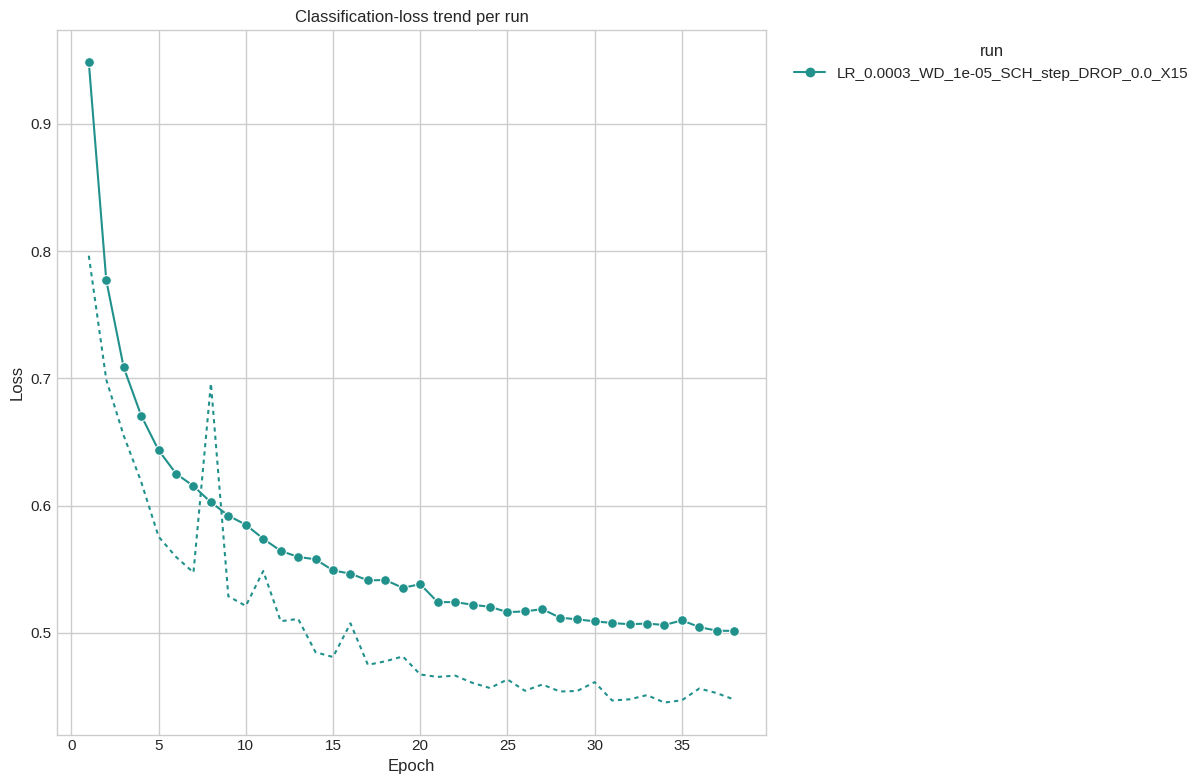

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

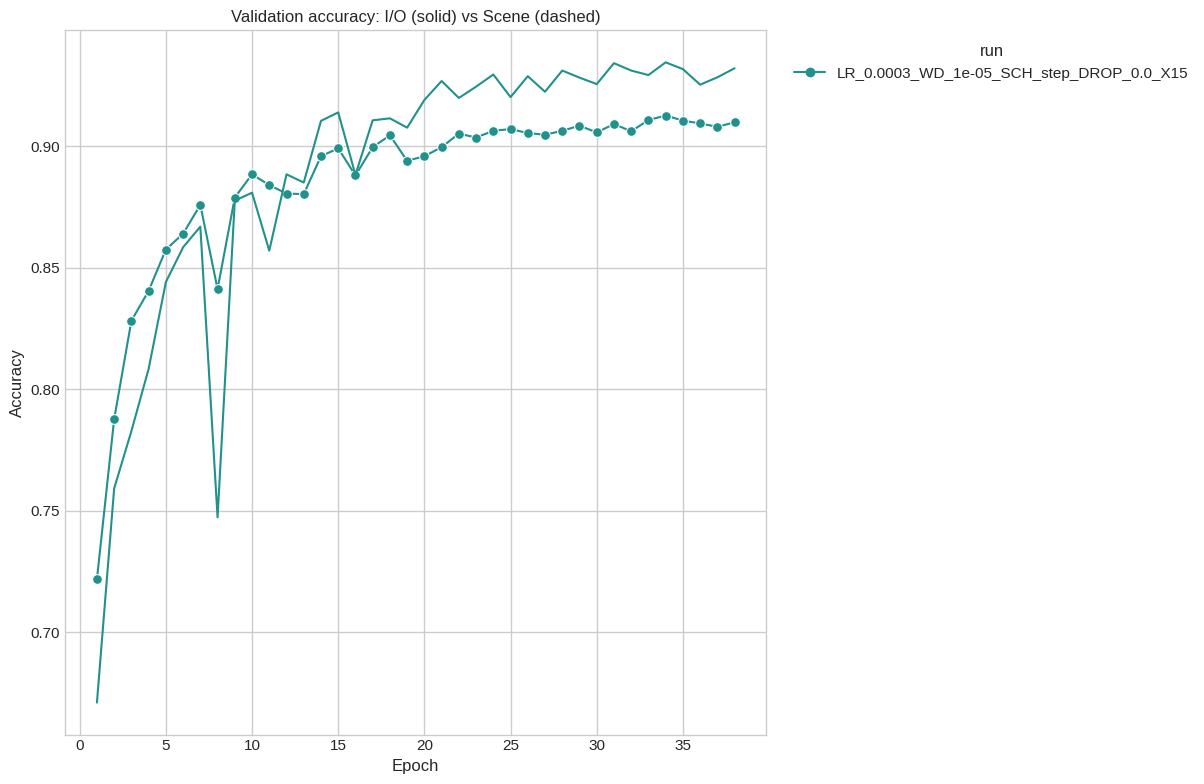

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


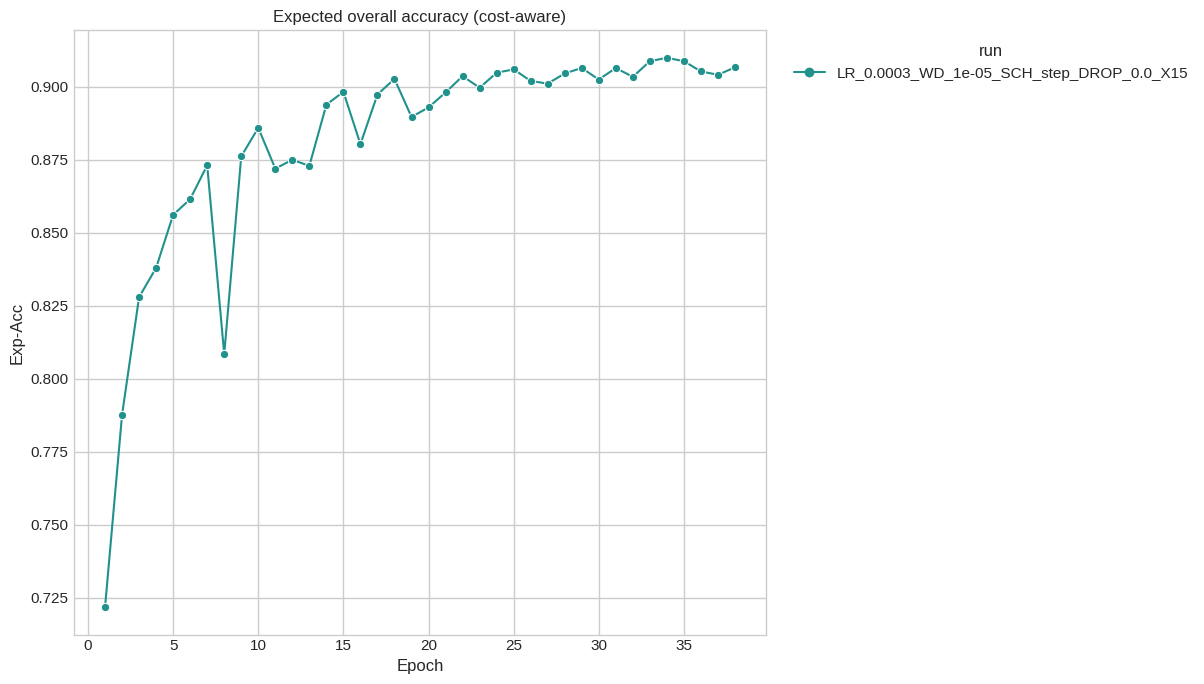

In [88]:
plot_data = []
for run_name, history in all_histories.items():
    for ep in history:
        ep["run_name"] = run_name
        plot_data.append(ep)

df = pd.DataFrame(plot_data)

# convenience: average scene accuracy over exits 1 & 2
df["vl_scene_avg"] = (df["vl_sc@1"] + df["vl_sc@2"]) / 2
df["tr_scene_avg"] = (df["tr_sc@1"] + df["tr_sc@2"]) / 2

run_names = df["run_name"].unique()
n_runs    = len(run_names)

# ------------------------------------ #
# 1.  LOSS curves (classification)      #
# ------------------------------------ #
plt.style.use("seaborn-v0_8-whitegrid")
palette   = sns.color_palette("viridis", n_colors=n_runs)
markers   = dict(zip(run_names, ['o','s','^','P','D','X','*','+']))

fig, ax1 = plt.subplots(figsize=(15,8))

sns.lineplot(
    data   = df,
    x      = "epoch",
    y      = "tr_cls",
    hue    = "run_name",
    style  = "run_name",
    dashes = False,
    markers= markers,
    palette= palette,
    ax     = ax1,
    legend = "full",
    markersize = 7
)

sns.lineplot(
    data   = df,
    x      = "epoch",
    y      = "vl_cls",
    hue    = "run_name",
    style  = "run_name",
    dashes = {r:(2,2) for r in run_names},   # dashed for validation
    palette= palette,
    ax     = ax1,
    legend = False
)

ax1.set(
    title = "Classification-loss trend per run",
    xlabel= "Epoch",
    ylabel= "Loss"
)
ax1.legend(title="run", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout(rect=[0,0,0.82,1])
plt.show()

# ------------------------------------ #
# 2.  VALIDATION accuracies             #
# ------------------------------------ #
fig, ax2 = plt.subplots(figsize=(15,8))

# I/O exit (exit-0) – solid & markers
sns.lineplot(
    data   = df,
    x      = "epoch",
    y      = "vl_io@0",
    hue    = "run_name",
    style  = "run_name",
    markers= markers,
    dashes = False,
    palette= palette,
    ax     = ax2,
    legend = "full",
    markersize = 7
)

# Scene (avg of exits 1+2) – dashed, no markers
sns.lineplot(
    data   = df,
    x      = "epoch",
    y      = "vl_scene_avg",
    hue    = "run_name",
    style  = "run_name",
    dashes = True,
    markers= False,
    palette= palette,
    ax     = ax2,
    legend = False
)

ax2.set(
    title = "Validation accuracy: I/O (solid) vs Scene (dashed)",
    xlabel= "Epoch",
    ylabel= "Accuracy"
)
handles, labels = ax2.get_legend_handles_labels()
ax2.legend(handles[:n_runs], labels[:n_runs],
           bbox_to_anchor=(1.02,1), loc="upper left", title="run")
plt.tight_layout(rect=[0,0,0.82,1])
plt.show()

# ------------------------------------ #
# 3.  Expected accuracy vs cost (extra) #
# ------------------------------------ #
fig, ax3 = plt.subplots(figsize=(15,7))
sns.lineplot(
    data   = df,
    x      = "epoch",
    y      = "vl_exp_acc",
    hue    = "run_name",
    style  = "run_name",
    markers= markers,
    palette= palette,
    ax     = ax3,
    markersize=6
)
ax3.set(title="Expected overall accuracy (cost-aware)", xlabel="Epoch", ylabel="Exp-Acc")
ax3.legend(bbox_to_anchor=(1.02,1), loc="upper left", title="run")
plt.tight_layout(rect=[0,0,0.82,1])
plt.show()

In [89]:
def evaluate_model_performance(model, loader, battery_level):
    model.eval()
    model.if_train = False

    # Accumulators
    total_samples      = 0
    overall_correct    = 0  # <<< RECOMMENDED: Use a single counter for overall accuracy
    exit_counts        = {1: 0, 2: 0, 3: 0}
    correct_at_exit    = {1: 0, 2: 0, 3: 0} # This now tracks per-exit task accuracy purely
    correct_io_later   = {2: 0, 3: 0}

    # Lists for F1
    y_true_io_exit1    = []
    y_pred_io_exit1    = []
    y_true_scene_exit2 = []
    y_pred_scene_exit2 = []
    y_true_scene_final = []
    y_pred_scene_final = []

    scene_encoder = loader.dataset.scene_label_encoder
    street_label_int = list(scene_encoder.classes_).index('Street')
    # Assuming 'Outdoor' is encoded as 1
    outdoor_label_int = list(loader.dataset.io_label_encoder.classes_).index('Outdoor')

    with torch.no_grad():
        for feats, io_lbls, sc_lbls in loader:
            total_samples += 1
            # --- setup ---
            assert feats.size(0) == 1, "eval expects bs=1"
            feats   = feats.float().to(device)
            io_lbls = io_lbls.view(-1).to(device).long()
            sc_lbls = sc_lbls.view(-1).to(device).long()
            batt    = torch.tensor([battery_level], device=device)
    
            # --- forward pass ---
            outs, exit_idx = model(feats, battery_level=batt)
            out0, io_preds = outs[0], outs[0].argmax(1)

            # --- Determine final exit path and check for shortcut ---
            is_outdoor_shortcut = (io_preds.item() == outdoor_label_int)
    
            final_exit_idx = 1 if is_outdoor_shortcut else int(exit_idx)
            exit_counts[final_exit_idx] += 1
    
            # =================================================================
            # <<< CORRECTED LOGIC FOR STATS COLLECTION >>>
            # =================================================================
            if final_exit_idx == 1:
                # This sample (computationally) exited at stage 1
                correct_at_exit[1] += (io_preds == io_lbls).item()
                y_true_io_exit1.append(io_lbls.item())
                y_pred_io_exit1.append(io_preds.item())

                if is_outdoor_shortcut:
                    # Overall correctness for a shortcut requires BOTH I/O and Scene to be correct
                    if (io_preds == io_lbls).item() and (sc_lbls.item() == street_label_int):
                        overall_correct += 1
                    # We still append to scene F1 lists to measure its performance
                    y_true_scene_exit2.append(sc_lbls.item())
                    y_pred_scene_exit2.append(street_label_int)
                else: # Indoor sample that exited early
                    # Overall correctness only depends on I/O, as no scene was predicted
                    if (io_preds == io_lbls).item():
                         overall_correct += 1
    
            elif final_exit_idx == 2:
                # This sample exited at stage 2
                scene_preds = outs[1].argmax(1)
                if (scene_preds == sc_lbls).item():
                    correct_at_exit[2] += 1
                    overall_correct += 1 # A correct scene prediction means overall correct
                
                y_true_scene_exit2.append(sc_lbls.item())
                y_pred_scene_exit2.append(scene_preds.item())
    
            else: # final_exit_idx == 3
                # This sample exited at the final stage
                scene_preds = outs[-1].argmax(1)
                if (scene_preds == sc_lbls).item():
                    correct_at_exit[3] += 1
                    overall_correct += 1 # A correct scene prediction means overall correct

                y_true_scene_final.append(sc_lbls.item())
                y_pred_scene_final.append(scene_preds.item())
    
            # I/O accuracy for samples that travelled past Exit-0 remains the same
            if final_exit_idx in (2, 3):
                correct_io_later[final_exit_idx] += (io_preds == io_lbls).item()

    # --- Compute aggregated metrics ---
    total = total_samples
    n1, n2, n3 = exit_counts[1], exit_counts[2], exit_counts[3]
    c1, c2, c3 = correct_at_exit[1], correct_at_exit[2], correct_at_exit[3]

    f1_io_exit1 = f1_score(y_true_io_exit1, y_pred_io_exit1, average='macro', zero_division=0) if y_true_io_exit1 else 0.0
    # NOTE: F1 for scene@2 now correctly includes shortcut predictions
    f1_scene_exit2 = f1_score(y_true_scene_exit2, y_pred_scene_exit2, average='weighted', zero_division=0) if y_true_scene_exit2 else 0.0
    f1_scene_final = f1_score(y_true_scene_final, y_pred_scene_final, average='weighted', zero_division=0) if y_true_scene_final else 0.0

    results = {
        'battery_level': battery_level,
        'exit_rates': { # This is now pure
            'exit1':  n1/total*100 if total else 0,
            'exit2':  n2/total*100 if total else 0,
            'exit3':  n3/total*100 if total else 0,
        },
        'accuracy_at_exit': { # These are now pure per-exit task accuracies
            'io@1':    c1/n1 if n1 else 0,
            'scene@2': c2/n2 if n2 else 0,
            'scene@3': c3/n3 if n3 else 0,
            'overall': overall_correct/total if total else 0, # <<< USES THE NEW COUNTER
        },
        'f1_macro_at_exit': {
            'f1_io@1':    f1_io_exit1,
            'f1_scene@2': f1_scene_exit2,
            'f1_scene@3': f1_scene_final,
        },
        'io_acc_later': {
            'io@2': correct_io_later[2]/n2 if n2 else 0,
            'io@3': correct_io_later[3]/n3 if n3 else 0,
        }
    }

    # print statement remains the same
    print(f"--- Eval @ batt={battery_level:.2f} | Rates: {results['exit_rates']} ---")
    print(f"Accuracies: {results['accuracy_at_exit']}")
    print(f"F1 macro: {results['f1_macro_at_exit']}")
    print(f"I/O later: {results['io_acc_later']}")
    print("-"*50)
    return results

BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.0003_WD_1e-05_SCH_step_DROP_0.0_X15/best_model.pth" # <--- UPDATE THIS PATH

model = DepthwiseEarlyExitCNN1D(
    if_train=False,
    train_shape=train_loader.dataset[0][0].shape,
    n_io=len(train_dataset.io_label_encoder.classes_),
    n_scene=len(train_dataset.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

battery_levels = np.linspace(0.5, 1, 5)
for b in battery_levels:
    evaluate_model_performance(model, test_loader, battery_level=b)

--- Eval @ batt=0.50 | Rates: {'exit1': 35.791838262822914, 'exit2': 35.679520778734556, 'exit3': 28.52864095844253} ---
Accuracies: {'io@1': 0.7421548117154811, 'scene@2': 0.859916054564533, 'scene@3': 0.6502624671916011, 'overall': 0.7579558217895919}
F1 macro: {'f1_io@1': 0.6415329473393989, 'f1_scene@2': 0.7979725706642329, 'f1_scene@3': 0.6547123326392572}
I/O later: {'io@2': 0.9569779643231899, 'io@3': 0.889763779527559}
--------------------------------------------------
--- Eval @ batt=0.62 | Rates: {'exit1': 52.71433919880195, 'exit2': 21.452639460876078, 'exit3': 25.833021340321977} ---
Accuracies: {'io@1': 0.7663352272727273, 'scene@2': 0.9476439790575916, 'scene@3': 0.7391304347826086, 'overall': 0.7982029202545863}
F1 macro: {'f1_io@1': 0.7641018589954143, 'f1_scene@2': 0.8028637926891129, 'f1_scene@3': 0.7342569614136695}
I/O later: {'io@2': 0.9921465968586387, 'io@3': 0.9449275362318841}
--------------------------------------------------
--- Eval @ batt=0.75 | Rates: {'ex

In [115]:
def evaluate_sensor_subset(model, loader, battery_level, sensor_slices, active_sensors):
    model.eval()
    model.if_train = False

    # Grab one batch just to get C and T
    T, C = loader.dataset[0][0].shape

    mask = torch.zeros(1, 1, C, device=device)
    for i in active_sensors:
        c0, c1 = sensor_slices[i]
        mask[..., c0:c1] = 1
        
    # Build hard mask on channel dim: shape (1, C, 1)
    # mask = torch.zeros(1, C, 1, device=device)
    # for i in active_sensors:
    #     c0, c1 = sensor_slices[i]
    #     mask[:, c0:c1, :] = 1

    total = 0
    exit_counts = {1: 0, 2: 0, 3: 0}
    correct_exit = {1: 0, 2: 0, 3: 0}
    y_true = {1: [], 2: [], 3: []}
    y_pred = {1: [], 2: [], 3: []}

    with torch.no_grad():
        for feats, io_lbls, sc_lbls in loader:
            # feats: (B, T, C)
            feats = feats.float().to(device) * mask   # still (B, T, C)
            io_lbls = io_lbls.view(-1).to(device)
            sc_lbls = sc_lbls.view(-1).to(device)
            bsz = feats.size(0)

            batt = torch.full((bsz,), battery_level, dtype=torch.float32, device=device)
            outs, exit_idx = model(feats, battery_level=batt)
            exit_idx = int(exit_idx)

            total += bsz
            exit_counts[exit_idx] += bsz

            if exit_idx == 1:
                preds = outs[0].argmax(dim=1); labels = io_lbls
            elif exit_idx == 2:
                preds = outs[1].argmax(dim=1); labels = sc_lbls
            else:
                preds = outs[2].argmax(dim=1); labels = sc_lbls

            correct_exit[exit_idx] += (preds == labels).sum().item()
            y_true[exit_idx].extend(labels.cpu().tolist())
            y_pred[exit_idx].extend(preds.cpu().tolist())

    # summarize
    exit_rates = {e: exit_counts[e]/total*100 for e in exit_counts}
    accuracy_at_exit = {
        e: correct_exit[e]/exit_counts[e] if exit_counts[e] else 0.0
        for e in exit_counts
    }
    overall_acc = sum(correct_exit.values()) / total

    f1_at_exit = {}
    for e in exit_counts:
        if exit_counts[e]:
            f1_at_exit[e] = f1_score(
                y_true[e], y_pred[e], average="macro", zero_division=0
            )
        else:
            f1_at_exit[e] = 0.0

    all_true = sum(y_true.values(), [])
    all_pred = sum(y_pred.values(), [])
    overall_f1 = (
        f1_score(all_true, all_pred, average="macro", zero_division=0)
        if total else 0.0
    )

    return {
        "active_sensors": active_sensors,
        "exit_rates":        exit_rates,
        "accuracy_at_exit":  accuracy_at_exit,
        "overall_acc":       overall_acc,
        "f1_at_exit":        f1_at_exit,
        "overall_f1":        overall_f1
    }

# FIX this

In [118]:
BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.003_WD_0.05_SCH_step_LAMBDA_0.05/best_model.pth"

model = DepthwiseEarlyExitCNN1D(
    if_train=False,
    train_shape=train_loader.dataset[0][0].shape,
    n_io=len(train_dataset.io_label_encoder.classes_),
    n_scene=len(train_dataset.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# battery_levels = np.linspace(0, 1, 11)

sensor_slices = [
    ( 0,  3),  # Acc: channels 0,1,2
    ( 3,  6),  # Mag: 3,4,5
    ( 6,  9),  # Gyro:6,7,8
    ( 9, 10),  # Press:9
    (10, 11),  # Temp:10
]
sensors_name = ["Acc", "Mag", "Gyro", "Press", "Temp"] # check the order of sensors
keep_sensors = [0, 1]

# keep only sensors[0] and sensors[1]
result = evaluate_sensor_subset(
    model=model,
    loader=test_loader,
    battery_level=1.0,
    sensor_slices=sensor_slices,
    active_sensors=list(range(len(sensor_slices)))
)

# Build list of kept sensor names
kept = [sensors_name[i] for i in keep_sensors]
print("Kept sensors:", ", ".join(kept))
print(f"Exit rates: {result['exit_rates']}")
print(f"Accuracy at exits: {result['accuracy_at_exit']}")
print(f"Overall accuracy: {result['overall_acc']:.3f}")

Kept sensors: Acc, Mag
Exit rates: {1: 0.018719580681392737, 2: 0.20591538749532012, 3: 99.77536503182328}
Accuracy at exits: {1: 1.0, 2: 1.0, 3: 0.850656660412758}
Overall accuracy: 0.851


In [16]:
import itertools
import json
import os

train_shape = train_ds[0][0].shape

model = DepthwiseEarlyExitCNN1D(
    if_train=True,
    train_shape=train_shape,
    n_io=len(train_ds.io_label_encoder.classes_),
    n_scene=len(train_ds.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

sensor_slices = [(0,6), (6,9), (9,12), (12,13), (13,14)]
sensor_indices = [0, 1, 2, 3, 4]
sensor_names = ["Acc", "Mag", "Gyro", "Press", "Temp"]

# Generate all non-empty subsets (combinations) of sensor indices
all_combinations = [
    list(combo)
    for r in range(1, len(sensor_indices) + 1)
    for combo in itertools.combinations(sensor_indices, r)
]

# Evaluate each combination and collect results
results = []
i = 1
for combo in all_combinations:
    print(f"Iteration {i}/{len(all_combinations)} Evaluating combo: {combo}")
    # Evaluate the model on this subset
    res = evaluate_sensor_subset(
        model=model,
        loader=test_loader,
        battery_level=0.5,
        sensor_slices=sensor_slices,
        active_sensors=combo
    )
    # Map indices to names for readability
    res["active_sensor_names"] = [sensor_names[i] for i in combo]
    results.append(res)

    i += 1

# Define output filepath
output_path = "/kaggle/working/b_1.0.json"

# Save results to JSON
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"Saved evaluation results for {len(results)} combinations")

Iteration 0/31 Evaluating combo: [0]
Iteration 1/31 Evaluating combo: [1]
Iteration 2/31 Evaluating combo: [2]
Iteration 3/31 Evaluating combo: [3]
Iteration 4/31 Evaluating combo: [4]
Iteration 5/31 Evaluating combo: [0, 1]
Iteration 6/31 Evaluating combo: [0, 2]
Iteration 7/31 Evaluating combo: [0, 3]
Iteration 8/31 Evaluating combo: [0, 4]
Iteration 9/31 Evaluating combo: [1, 2]
Iteration 10/31 Evaluating combo: [1, 3]
Iteration 11/31 Evaluating combo: [1, 4]
Iteration 12/31 Evaluating combo: [2, 3]
Iteration 13/31 Evaluating combo: [2, 4]
Iteration 14/31 Evaluating combo: [3, 4]
Iteration 15/31 Evaluating combo: [0, 1, 2]
Iteration 16/31 Evaluating combo: [0, 1, 3]
Iteration 17/31 Evaluating combo: [0, 1, 4]
Iteration 18/31 Evaluating combo: [0, 2, 3]
Iteration 19/31 Evaluating combo: [0, 2, 4]
Iteration 20/31 Evaluating combo: [0, 3, 4]
Iteration 21/31 Evaluating combo: [1, 2, 3]
Iteration 22/31 Evaluating combo: [1, 2, 4]
Iteration 23/31 Evaluating combo: [1, 3, 4]
Iteration 24/3

## Evaluating performance

In [80]:
def count_parameters(model):
    """Counts the total number of trainable parameters in a PyTorch model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

BEST_MODEL_PATH = "/kaggle/working/validation_runs/LR_0.0003_WD_1e-05_SCH_step_DROP_0.0_X15/best_model.pth" # <--- UPDATE THIS PATH

model = DepthwiseEarlyExitCNN1D(
    if_train=False,
    train_shape=train_loader.dataset[0][0].shape,
    n_io=len(train_dataset.io_label_encoder.classes_),
    n_scene=len(train_dataset.scene_label_encoder.classes_)
).to(device)

# Load the weights of your chosen best model
model.load_state_dict(torch.load(BEST_MODEL_PATH))

# Now, call the function to get the count
total_params = count_parameters(model)
print(f"Total Trainable Parameters: {total_params:}")

estimated_size = total_params * 4 / 1000 # FP32 precision
print(f"Estimated Size: {estimated_size:,} KB")

Total Trainable Parameters: 13610
Estimated Size: 54.44 KB


In [215]:
from torchinfo import summary

model = DepthwiseEarlyExitCNN1D(
    if_train=False,
    train_shape=train_loader.dataset[0][0].shape,
    n_io=len(train_dataset.io_label_encoder.classes_),
    n_scene=len(train_dataset.scene_label_encoder.classes_)
).to(device)

# Print summary
summary(
    model, 
    input_size=(1, 11, 600), 
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    verbose=2,  # Detailed output
    device=device
)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []

# TODO
- Data Augmentation for Time-Series Data
- attention mechanism

# TO DELETE THE /kaggle/working/ FILES

In [162]:
import shutil
import os

directory_path = "/kaggle/working/validation_runs/"

if os.path.exists(directory_path):
    shutil.rmtree(directory_path)
    print(f"Deleted directory {directory_path}")
else:
    print(f"Directory {directory_path} not found")

Deleted directory /kaggle/working/validation_runs/
